In [1]:
import tensorflow as tf

In [2]:
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.5.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
path = '/gdrive/My Drive/'

<h1> Load Module </h1>

In [5]:
from keras import models, layers, optimizers, utils
from keras.layers import Dropout, Activation, Dense, BatchNormalization
from keras.models import load_model

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import load_img
import random
import cv2, os, sys
from keras.preprocessing import image
from PIL import Image

In [7]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from numpy import expand_dims

<h1> Load Image </h1>

In [8]:
# 이미지 크기 지정

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [9]:
# 트레이닝 데이터 파일을 정렬
import natsort
train_order = os.listdir(path+'04_multimodal_training')
train_order = natsort.natsorted(train_order)

In [10]:
# Image Augmentation 생성
datagen = ImageDataGenerator(
            width_shift_range = 0.01,
            height_shift_range = 0.01,
            horizontal_flip = True,
            vertical_flip = True,
            zoom_range = 0.05,
            brightness_range=[1.0, 1.0])

In [11]:
# 이미지를 64개의 카테고리로 분류
nb_classes = 64

data = []
label= []
dtype = []

for filename in train_order:
    category = filename[:3]
    imagePath = path + '/04_multimodal_training/' + filename
    if filename[4:8] == 'face':
      dtype.append('F')
    elif filename[4:8] == 'iris':
      dtype.append('I')

    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
    
    data.append(image)
    label.append(int(category))
    new_image = img_to_array(image)
    samples = expand_dims(new_image, 0)
    it= datagen.flow(samples, batch_size=1)

    # 이미지를 15개씩 augmentation
    for i in range(15):
        batch = it.next()
        image = batch[0].astype('uint8')
        np_image = np.array(image)

        data.append(np_image)
        label.append(int(category))
        
        # 이미지의 종류에 따라 타입 설정
        if filename[4:8] == 'face':
          dtype.append('F')
        elif filename[4:8] == 'iris':
          dtype.append('I')

In [12]:
# iris와 face 각각 훈련데이터셋 형성

face_X = []
face_Y = []
iris_X = []
iris_Y = []

for i in range((len(data))):
  tmp = []
  if dtype[i] == 'F':
    face_X.append(data[i])
    face_Y.append(label[i])
  elif dtype[i] == 'I':
    iris_X.append(data[i])
    iris_Y.append(label[i])

In [13]:
# 두 데이터셋을 짝지어 하나로 합침

train_X = []
train_Y = []

l = 0
for i in range(len(face_X)):
  data[i]
  train_X.append(face_X[i]+iris_X[i])
  train_Y.append(face_Y[i])

<h1> Build Iris Model </h1>

In [14]:
from keras import utils as np_utils
from keras.layers import Input, Dense
from keras.applications.resnet_v2 import ResNet50V2

from keras.layers import GlobalAveragePooling2D, BatchNormalization
from keras.metrics import Precision, Recall
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical

In [16]:
# ResNet Pre-trained Model 사용

def build_model():

    input = Input(shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    base_model = ResNet50V2(include_top = False, weights = 'imagenet', input_tensor = input)

    for layer in base_model.layers[:44]:
      layer.trainable = False

    X = base_model.output
    X = BatchNormalization()(X)
    X = GlobalAveragePooling2D()(X)
    X = Dense(512, activation = 'relu')(X)
    X = Dropout(0.5)(X)

    Y = Dense(64, activation='softmax')(X)

    model = tf.keras.Model(inputs = input, outputs = Y)

    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics=['accuracy',Precision(),Recall()])
    model.summary()

    return model

In [17]:
model = build_model()
model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 24,654,912
Trainable params: 24,346,432
Non-trainable params: 308,480
__________________________________________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 24,654,912
Trainable params: 24,346,432
Non-trainable params: 308,480
__________________________________________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
# 이미지 훈련을 3회로 분할해 교차검증 진행
skf = StratifiedKFold(n_splits=3)

In [19]:
#모델을 사용한 훈련 진행

all_history = []
all_acc = []
all_f1 = []
all_recall = []
all_precision = []

for train_index, test_index in skf.split(train_X, train_Y):
    X_train, X_test, Y_train, Y_test = train_test_split(train_X,
                                                         train_Y,
                                                         test_size = 0.3,
                                                         random_state=10)
    

    X_train = np.array(X_train)
    X_test = np.array(X_test)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    Y_train = to_categorical(Y_train, nb_classes)
    Y_test = to_categorical(Y_test, nb_classes)

    X_train /= 255
    X_test /= 255

    history = model.fit(X_train, Y_train, epochs = 60, batch_size = 128, verbose = 1)
    all_history.append(history.history)

    Y_pred = model.predict(X_test)
    Y_pred_binary = np.around(Y_pred)

    acc = accuracy_score(Y_test, Y_pred_binary)
    f1 = f1_score(Y_test, Y_pred_binary, average = 'micro')
    recall = recall_score(Y_test, Y_pred_binary, average = 'micro')
    precision = precision_score(Y_test, Y_pred_binary, average = 'micro')
    
    all_acc.append(acc)
    all_f1.append(f1)
    all_recall.append(recall)
    all_precision.append(precision)

Epoch 1/60
23/23 [==============================] - 63s 848ms/step - loss: 3.1762 - accuracy: 0.2525 - precision: 0.4648 - recall: 0.0144
Epoch 2/60
23/23 [==============================] - 17s 732ms/step - loss: 0.5543 - accuracy: 0.8409 - precision: 0.9041 - recall: 0.2730
Epoch 3/60
23/23 [==============================] - 17s 745ms/step - loss: 0.0831 - accuracy: 0.9791 - precision: 0.9428 - recall: 0.5282
Epoch 4/60
23/23 [==============================] - 17s 757ms/step - loss: 0.0373 - accuracy: 0.9892 - precision: 0.9621 - recall: 0.6588
Epoch 5/60
23/23 [==============================] - 18s 778ms/step - loss: 0.0241 - accuracy: 0.9948 - precision: 0.9707 - recall: 0.7321
Epoch 6/60
23/23 [==============================] - 18s 779ms/step - loss: 0.0917 - accuracy: 0.9850 - precision: 0.9757 - recall: 0.7790
Epoch 7/60
23/23 [==============================] - 18s 772ms/step - loss: 0.0063 - accuracy: 0.9997 - precision: 0.9790 - recall: 0.8115
Epoch 8/60
23/23 [================

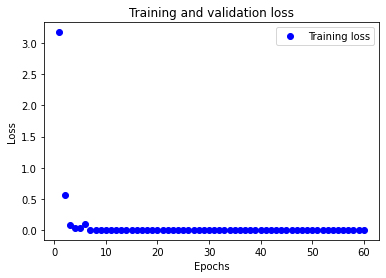

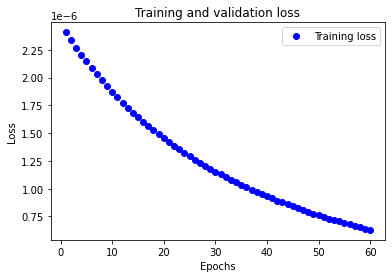

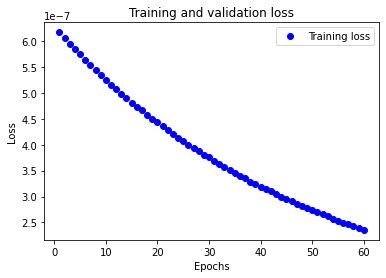

In [20]:
# 훈련 단계 별 Training and validation loss

for i in range(3):
    loss =all_history[i]['loss']
    #val_loss = all_history[i]['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss') 
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [21]:
# accuracy

accuracy = sum(all_acc)/3

print('Average accuracy : ', accuracy)
print('Average recall : ', sum(all_recall)/3)
print('Average F1 score : ', sum(all_f1)/3)
print('Average precision : ', sum(all_precision)/3)

Average accuracy :  0.9951179820992677
Average recall :  0.9951179820992677
Average F1 score :  0.995928338762215
Average precision :  0.9967400162999184


In [22]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.01583733782172203
Test accuracy: 0.9951179623603821


<h1> Build Face Model </h1>

<h1> Test </h1>

In [23]:
import pandas as pd

In [24]:
# 테스트데이터 파일을 숫자 순으로 정렬
import natsort
order_list = os.listdir(path+'04_multimodal_test')
order_list = natsort.natsorted(order_list)

In [25]:
print(order_list)

['0_face.png', '0_iris.png', '1_face.png', '1_iris.png', '2_face.png', '2_iris.png', '3_face.png', '3_iris.png', '4_face.png', '4_iris.png', '5_face.png', '5_iris.png', '6_face.png', '6_iris.png', '7_face.png', '7_iris.png', '8_face.png', '8_iris.png', '9_face.png', '9_iris.png', '10_face.png', '10_iris.png', '11_face.png', '11_iris.png', '12_face.png', '12_iris.png', '13_face.png', '13_iris.png', '14_face.png', '14_iris.png', '15_face.png', '15_iris.png', '16_face.png', '16_iris.png', '17_face.png', '17_iris.png', '18_face.png', '18_iris.png', '19_face.png', '19_iris.png', '20_face.png', '20_iris.png', '21_face.png', '21_iris.png', '22_face.png', '22_iris.png', '23_face.png', '23_iris.png', '24_face.png', '24_iris.png', '25_face.png', '25_iris.png', '26_face.png', '26_iris.png', '27_face.png', '27_iris.png', '28_face.png', '28_iris.png', '29_face.png', '29_iris.png', '30_face.png', '30_iris.png', '31_face.png', '31_iris.png', '32_face.png', '32_iris.png', '33_face.png', '33_iris.png',

In [26]:
# face와 test 각각 배열에 저장
face_test = []
iris_test = []
tmp = []

for filename in order_list:
    imagePath = path + '/04_multimodal_test/' + filename

    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

    i = 0
    if filename[-8:-4] == 'face':
      face_test.append(image)
    elif filename[-8:-4] == 'iris':
      iris_test.append(image)

In [27]:
test_X = []

for i in range(len(face_test)):
  test_X.append(face_test[i]+iris_test[i])

In [28]:
# model predict
test_X = np.array(test_X)
test_X = test_X.astype('float32')
test_X /= 255
pred = model.predict(test_X).argmax(1)

In [ ]:
# model result
pred

array([27, 31, 22, 57, 54, 45,  5, 12,  8,  7, 36,  2, 46, 50, 10, 61, 49,
       59, 56, 13, 37, 30, 25,  0, 41, 58,  9, 20, 48, 47, 42, 24,  3,  6,
       55, 63, 21, 16, 34, 11, 35, 32, 40, 62, 19, 52, 33, 15,  1, 29, 17,
       26, 53, 28, 18, 14, 43, 60,  4, 39, 38, 23, 51, 44])

<h1> Result </h1>

In [30]:
result = pd.DataFrame({'Image':[],
                 'Answer':[]})

In [32]:
for i in range(len(pred)):
  new_data = {'Image':int(i), 'Answer':int(pred[i])}
  result = result.append(new_data, ignore_index = True)

In [33]:
result

,Image,Answer
0,0.0,27.0
1,1.0,31.0
2,2.0,34.0
3,3.0,57.0
4,4.0,54.0
...,...,...
59,59.0,39.0
60,60.0,38.0
61,61.0,23.0
62,62.0,51.0


In [34]:
result.to_csv('/gdrive/My Drive/multimodal_result.csv')